@Farhan: This is a copy of the file from P23-18 Transitiemanager we discussed in 19/08/2024. You can used snippets from it to create a workbook for the creation of a zoning layer for Hasselt (or convert this one into the workbook for Hasselt).

# Extract buildings from OSM

Install required libraries using the Conda conda-forge channel
````bash
conda install -c conda-forge jupyter
conda install -c conda-forge requests
````

Download relevant files to `./data`

In [1]:
import os
import requests

os.makedirs("./data", exist_ok=True)  # create data folder if not exist


# Download file
def dlfile(furl, fname):
    if not os.path.isfile(fname):
        print(f"File {fname} does not exist.")
        print(f"Downloading from {furl}")

        chunk_size = 4096
        with requests.get(furl, stream=True) as r:
            with open(fname, "wb") as f:
                for chunk in r.iter_content(chunk_size):
                    if chunk:
                        f.write(chunk)
    else:
        print(f"File {fname} is available.")


print("Acquiring required data")

# Statistische sectoren
SSUrl = "https://statbel.fgov.be/sites/default/files/files/opendata/Statistische%20sectoren/sh_statbel_statistical_sectors_3812_20230101.shp.zip"
SSFile = "./data/sh_statbel_statistical_sectors_3812_20230101.shp.zip"
dlfile(SSUrl, SSFile)

# Bevolking per statistische sector
BVSSUrl = "https://statbel.fgov.be/sites/default/files/files/opendata/bevolking/sectoren/OPEN%20DATA_SECTOREN_2019.xlsx"
BVSSFile = "./data/OPEN_DATA_SECTOREN_2019.xlsx"
dlfile(BVSSUrl, BVSSFile)

# OSM data voor België
OSMUrl = "https://download.geofabrik.de/europe/belgium-latest.osm.pbf"
OSMFile = "./data/belgium.osm.pbf"
dlfile(OSMUrl, OSMFile)

Acquiring required data
File ./data/sh_statbel_statistical_sectors_3812_20230101.shp.zip is available.
File ./data/OPEN_DATA_SECTOREN_2019.xlsx is available.
File ./data/belgium.osm.pbf is available.


## (Optioneel/test) Cut de oorspronkelijke pbf bestanden in kleinere
Gebruik Osmium.

````bash
pip install osmium
````

Cut obv boudning box.
Bounding box tool: https://boundingbox.klokantech.com/ (selecteer CSV).

- AVBL (Antwerpen, Vlaams-Brabant, Limburg): 3.85,50.7121,6.1183,51.5039
- Hasselt: 5.265463,50.894442,5.452711,50.956291

````bash
# AVBL
osmium extract --bbox 3.85,50.7121,6.1183,51.5039 ./data/belgium.osm.pbf -o ./data/AVBL.osm.pbf
# Hasselt
osmium extract --bbox 5.265463,50.894442,5.452711,50.956291 ./data/belgium.osm.pbf -o ./data/Hasselt.osm.pbf
````


In [2]:
# Gebruik voor tests het beperkte bestand
!osmium extract --overwrite --bbox 5.265463,50.894442,5.452711,50.956291 ./data/belgium.osm.pbf -o ./data/Hasselt.osm.pbf
OSMFile = "./data/Hasselt.osm.pbf" 
OSMUrl = ""

#!osmium extract --overwrite --bbox 3.85,50.7121,6.1183,51.5039 ./data/belgium.osm.pbf -o ./data/AVBL.osm.pbf
#OSMFile = "./data/AVBL.osm.pbf" 
#OSMUrl = ""


# Create shp files with populatie

Use official data from the statistical center and start from the SS to create files for DLG and GEM level.

In [3]:
import geopandas as gpd

# gpd.options.io_engine = "pyogrio"
# import fiona

# https://geopandas.org/en/v0.14.0/docs/user_guide/io.html
#     where="CNIS_PROVI='70000'",
#     where="(CNIS_PROVI IN ('70000', '20001', '10000')) OR ( CNIS_PROVI IS NULL)",
gdf_SS = gpd.read_file(
    f"zip://{SSFile}!sh_statbel_statistical_sectors_3812_20230101.shp",
    where="(CNIS_PROVI IN ('70000', '20001', '10000')) OR ( CNIS_PROVI IS NULL)",
    columns=[
        "CS01012023",
        "CNIS_PROVI",
        "T_SEC_NL",
        "CNIS_REGIO",
        "T_ARRD_NL",
        "T_MUN_NL",
        "CNIS5_2023",
        "C_NIS6",
        "T_NIS6_NL",
    ],
)
# Pyogrio: https://pyogrio.readthedocs.io/en/latest/introduction.html#read-a-subset-of-columns
# gdf = gdf[["CS01012023",
#        "CNIS_PROVI",
#        "T_SEC_NL",
#        "CNIS_REGIO",
#        "T_ARRD_NL",
#        "T_MUN_NL", "geometry"
#    ]]
print(gdf_SS.columns)
gdf_SS.head()

Index(['CS01012023', 'T_SEC_NL', 'T_SEC_FR', 'T_SEC_DE', 'C_NIS7', 'C_NIS6',
       'T_NIS6_NL', 'T_NIS6_FR', 'MUN_DISTR', 'CNIS5_2023', 'T_MUN_NL',
       'T_MUN_FR', 'T_MUN_DE', 'CNIS_ARRD_', 'T_ARRD_NL', 'T_ARRD_FR',
       'T_ARRD_DE', 'CNIS_PROVI', 'T_PROVI_NL', 'T_PROVI_FR', 'T_PROVI_DE',
       'CNIS_REGIO', 'T_REGIO_NL', 'T_REGIO_FR', 'T_REGIO_DE', 'C_COUNTRY',
       'NUTS1_2021', 'NUTS2_2021', 'NUTS3_2021', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')


,CS01012023,T_SEC_NL,T_SEC_FR,T_SEC_DE,C_NIS7,C_NIS6,T_NIS6_NL,T_NIS6_FR,MUN_DISTR,CNIS5_2023,...,T_REGIO_NL,T_REGIO_FR,T_REGIO_DE,C_COUNTRY,NUTS1_2021,NUTS2_2021,NUTS3_2021,Shape_Leng,Shape_Area,geometry
0,11001A00-,AARTSELAAR-CENTRUM,AARTSELAAR-CENTRUM,AARTSELAAR-CENTRUM,11001A0,11001A,AARTSELAAR,AARTSELAAR,None,11001,...,Vlaams Gewest,Région flamande,Flämische Region,BE,BE2,BE21,BE211,5248.083447,531581.002667,"POLYGON Z ((651655.772 703013.948 0.000, 65184..."
1,11001A01-,DE LEEUWERIK,DE LEEUWERIK,DE LEEUWERIK,11001A0,11001A,AARTSELAAR,AARTSELAAR,None,11001,...,Vlaams Gewest,Région flamande,Flämische Region,BE,BE2,BE21,BE211,3934.734644,671146.789684,"POLYGON Z ((651744.222 703170.832 0.000, 65173..."
2,11001A020,BUERSTEDE,BUERSTEDE,BUERSTEDE,11001A0,11001A,AARTSELAAR,AARTSELAAR,None,11001,...,Vlaams Gewest,Région flamande,Flämische Region,BE,BE2,BE21,BE211,2201.715993,280843.644287,"POLYGON Z ((650632.112 702982.154 0.000, 65052..."
3,11001A030,YSSELAAR,YSSELAAR,YSSELAAR,11001A0,11001A,AARTSELAAR,AARTSELAAR,None,11001,...,Vlaams Gewest,Région flamande,Flämische Region,BE,BE2,BE21,BE211,3403.263242,428118.516129,"POLYGON Z ((651580.191 703830.135 0.000, 65152..."
4,11001A042,KLEINE GRIPPE,KLEINE GRIPPE,KLEINE GRIPPE,11001A0,11001A,AARTSELAAR,AARTSELAAR,None,11001,...,Vlaams Gewest,Région flamande,Flämische Region,BE,BE2,BE21,BE211,2166.457207,255619.546873,"POLYGON Z ((651744.222 703170.832 0.000, 65172..."


Load excel file with population per SS in Pandas dataframe

````bash
conda install -c conda-forge openpyxl
````

In [4]:
import pandas as pd

# bvss = pd.read_excel(BVSSFile)
bvss = pd.read_excel(BVSSFile, usecols=["POPULATION", "CD_SECTOR"])
bvss.head()

,CD_SECTOR,POPULATION
0,11001A00-,2509
1,11001A01-,2687
2,11001A020,713
3,11001A030,436
4,11001A042,350


Join bvss dataframe with population with geodataframe with SS data to add population data per SS to the SS shapefile.

In [5]:
gdf_SS = gdf_SS.merge(bvss, left_on="CS01012023", right_on="CD_SECTOR")
gdf_SS.head()
# drop unneeded foreign key column before export
gdf_SS = gdf_SS.drop(["CD_SECTOR"], axis="columns")
gdf_SS.to_file("./data/SS_pop.shp")

Create shapefiles for DLG and GEM by aggregation of SS.

In [6]:
# Aggregate SS to DLG
gdf_DLG = gdf_SS.dissolve(
    by="C_NIS6",  # Do not aggregate on T_NIS6_NL as it cannot be an index: duplicate names!
    aggfunc={  # Only listed columns are exported/aggregated
        "CNIS_PROVI": "first",
        "CNIS_REGIO": "first",
        "T_ARRD_NL": "first",
        "T_MUN_NL": "first",
        "T_NIS6_NL": "first",
        "CNIS5_2023": "first",
        "POPULATION": "sum",
    },
).reset_index()  # reset newly created C_NIS6 index to a regular column
gdf_DLG.to_file("./data/DLG_pop.shp")

# Aggregate DLG to GEM
gdf_GEM = gdf_DLG.dissolve(
    by="CNIS5_2023",  # Do not aggregate on T_MUN_NL as it is a label and not necessarily unique
    aggfunc={  # Only listed columns are exported/aggregated
        "CNIS_PROVI": "first",
        "CNIS_REGIO": "first",
        "T_ARRD_NL": "first",
        "POPULATION": "sum",
        "T_MUN_NL": "first",
    },
).reset_index()  # reset newly created CNIS5_2023 index to a regular column
gdf_GEM.to_file("./data/GEM_pop.shp")

## Extract building data from pbf file

Maak een polygoon voor Limburg om mee te filteren: LimburgGrenzen.
Lees de gebouwen in.
Centroids

In [7]:
## First try: Pyrosm. Does not scale well (memory consumption)
# from pyrosm import OSM, get_data
#
# osm = OSM(OSMFile)
# buildings = osm.get_buildings()
# buildings.plot()

Use Osmium to process OSM pbf file

````bash
conda install -c conda-forge osmium-tool
# Besides osmium-tool, osmium itself needs to be installed as well
pip install osmium
````
https://max-coding.medium.com/extracting-open-street-map-osm-street-data-from-data-files-using-pyosmium-afca6eaa5d00

https://github.com/osmcode/pyosmium/blob/master/examples/amenity_list.py

https://stackoverflow.com/questions/10715965/create-a-pandas-dataframe-by-appending-one-row-at-a-time

In [8]:
# Sample code counting the nodes in the OSMFile pbf file

import osmium


class CounterHandler(osmium.SimpleHandler):
    def __init__(self):
        osmium.SimpleHandler.__init__(self)
        self.num_nodes = 0

    def node(self, n):
        self.num_nodes += 1


h = CounterHandler()
h.apply_file(OSMFile)
print("Number of nodes: %d" % h.num_nodes)

Number of nodes: 515705


In [9]:
# Extract buildings from OSMFile pbf file

import osmium
import shapely.wkt as wktlib
import geopandas

# A global factory that creates WKB from a osmium geometry
wktfab = osmium.geom.WKTFactory()

# create transformer object for Shapely object crs transformation from
# .. -> ... needed for the area computation
# see docs: https://shapely.readthedocs.io/en/latest/manual.html#shapely.ops.transform
import pyproj
from shapely.ops import transform

ss_crs = gdf_SS.crs  # use the orthonormal projection system from the SS layer
project = pyproj.Transformer.from_crs(
    pyproj.CRS("EPSG:4326"), ss_crs, always_xy=True
).transform


class CounterHandler(osmium.SimpleHandler):
    def __init__(self):
        osmium.SimpleHandler.__init__(self)
        self.num_nodes = 0
        self.building_values = []
        self.amenity_values = []
        self.buildings = []
        self.building_area = []

    def area(self, n):
        if "building" in n.tags:
            try:
                wkt = wktfab.create_multipolygon(n)
                self.num_nodes += 1
                area = wktlib.loads(wkt)
                # print(n.tags["building"])
                self.buildings.append(area.centroid)
                self.building_values.append(n.tags.get("building"))
                #                self.building_values.update([k for k, v in n.tags])
                #                if "amenity" in n.tags:
                self.amenity_values.append(n.tags.get("amenity"))
                self.building_area.append(
                    transform(project, area).area
                )  # transform before computing area (inefficient!)
                if self.num_nodes % 250000 == 0:  # report one in 250000 buildings
                    print(f"{area.centroid} : {n.tags}")
                    print(f"Building: {n.tags.get('building')}")
                    print(f"Amenity: {n.tags.get('amenity')}")
            except:
                print("Trouble with polygons ...")


h = CounterHandler()
h.apply_file(OSMFile, locations=True)
print("Number of nodes: %d" % len(h.buildings))
print(f"Buildings: {h.building_values}")
print(f"Amenities: {h.amenity_values}")

Number of nodes: 52403
Buildings: ['yes', 'sports_hall', 'school', 'university', 'yes', 'yes', 'office', 'industrial', 'industrial', 'industrial', 'industrial', 'industrial', 'industrial', 'industrial', 'industrial', 'industrial', 'industrial', 'retail', 'industrial', 'commercial', 'commercial', 'commercial', 'industrial', 'industrial', 'industrial', 'hospital', 'industrial', 'commercial', 'industrial', 'industrial', 'retail', 'yes', 'office', 'yes', 'college', 'school', 'house', 'yes', 'school', 'school', 'school', 'school', 'industrial', 'industrial', 'industrial', 'industrial', 'industrial', 'house', 'industrial', 'school', 'office', 'yes', 'yes', 'yes', 'office', 'industrial', 'retail', 'commercial', 'yes', 'school', 'church', 'university', 'school', 'school', 'yes', 'office', 'office', 'school', 'yes', 'yes', 'yes', 'school', 'house', 'service', 'yes', 'yes', 'yes', 'industrial', 'industrial', 'yes', 'yes', 'yes', 'yes', 'yes', 'retail', 'yes', 'commercial', 'yes', 'retail', 'yes'

## Write some statistics on the imported data

https://www.tutorialspoint.com/how-to-count-occurrences-of-specific-value-in-pandas-column 

This does not work for Python series directly, rather, we first convert to a Pandas Series object and use the values_counts() method.

Note: Alternative is to call the values_counts method later on the columns of the blding_centroids GeoDataFrame.

In [10]:
import pandas as pd
import openpyxl

building_value_counts = pd.Series(h.building_values).value_counts()
amenity_value_counts = pd.Series(h.amenity_values).value_counts()

print(f"Buildings values: {building_value_counts}")
print(f"Amenities values: {amenity_value_counts}")

# write results to excel file
with pd.ExcelWriter("./data/tag_stats.xlsx") as writer:
    building_value_counts.to_excel(writer, "building")
    amenity_value_counts.to_excel(writer, "amenity")

Buildings values: house         20438
yes           16536
shed           6944
roof           2771
detached       1711
              ...  
monastery         1
cathedral         1
shrine            1
tower             1
substation        1
Name: count, Length: 62, dtype: int64
Amenities values: community_centre    73
shelter             59
place_of_worship    37
restaurant          36
social_facility     34
bicycle_parking     33
pub                 30
fast_food           29
pharmacy            11
college              9
kindergarten         8
school               7
fuel                 7
cafe                 7
parking              5
bar                  4
university           4
bank                 4
police               4
ice_cream            3
brothel              3
townhall             3
car_wash             3
arts_centre          3
library              3
kot                  2
theatre              2
toilets              2
monastery            2
doctors              2
events_venue    

C:\Users\lucp13374\AppData\Local\Temp\ipykernel_28752\241248925.py:12: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  building_value_counts.to_excel(writer, "building")
C:\Users\lucp13374\AppData\Local\Temp\ipykernel_28752\241248925.py:13: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  amenity_value_counts.to_excel(writer, "amenity")


## Write shapefile with centroids to file

In [11]:
import geopandas as gpd


print(h.building_values)

# bldng_centroids = gpd.GeoDataFrame( geometry=h.buildings, crs="EPSG:4326")
# bldng_centroids = gpd.GeoDataFrame({'building': h.building_values, 'amenity': h.amenity_values, 'geometry': gpd.GeoSeries(h.buildings)}, crs="EPSG:4326")
bldng_centroids = gpd.GeoDataFrame(
    {
        "building": h.building_values,
        "amenity": h.amenity_values,
        "area": h.building_area,
        "geometry": h.buildings,
    },
    geometry="geometry",
    crs="EPSG:4326",
)

bldng_centroids = bldng_centroids.to_crs(gdf_SS.crs)  # reproject to SS shapefile crs

bldng_centroids.to_file("./data/bldng_centroids.shp")

['yes', 'sports_hall', 'school', 'university', 'yes', 'yes', 'office', 'industrial', 'industrial', 'industrial', 'industrial', 'industrial', 'industrial', 'industrial', 'industrial', 'industrial', 'industrial', 'retail', 'industrial', 'commercial', 'commercial', 'commercial', 'industrial', 'industrial', 'industrial', 'hospital', 'industrial', 'commercial', 'industrial', 'industrial', 'retail', 'yes', 'office', 'yes', 'college', 'school', 'house', 'yes', 'school', 'school', 'school', 'school', 'industrial', 'industrial', 'industrial', 'industrial', 'industrial', 'house', 'industrial', 'school', 'office', 'yes', 'yes', 'yes', 'office', 'industrial', 'retail', 'commercial', 'yes', 'school', 'church', 'university', 'school', 'school', 'yes', 'office', 'office', 'school', 'yes', 'yes', 'yes', 'school', 'house', 'service', 'yes', 'yes', 'yes', 'industrial', 'industrial', 'yes', 'yes', 'yes', 'yes', 'yes', 'retail', 'yes', 'commercial', 'yes', 'retail', 'yes', 'dormitory', 'detached', 'detach

# Count the OSM points in each of the statistical sectors
Based on the following example: https://medium.com/@nygeog/data-science-methods-focus-geoprocessing-with-geopandas-using-spatial-joins-counting-points-e42d1b36d758

Note: this merely counts the number of points. If we can have points belonging to different categories (e.g. for different amenities), we can use the Pandas pivot table approach as in: https://gis.stackexchange.com/questions/306674/geopandas-spatial-join-and-count

In [12]:
# Join dataframes
joined_gdf = gdf_SS.sjoin(
    bldng_centroids,
    how="inner",
    predicate="intersects",
)
# Groepeer op SS en tel
ss_count_bldngs = joined_gdf.groupby(
    ["CS01012023"],
    as_index=False,
)[
    "building"
].count()  # this counts the non Null values, so choose column that has no Null
ss_count_bldngs = ss_count_bldngs.rename(columns={"building": "bldng_cnt"})
# ss_count_bldngs.columns = ['building', 'bldng_cnt']  # column rename alternative
# print(ss_count_bldngs.head())

# Merge dataframe with counts per SS back into the dataframe with the SS
# print(gdf.head())
gdf_cnts = gdf_SS.merge(
    ss_count_bldngs,
    on="CS01012023",
    how="left",
)
# print(gdf_cnts.head())

# Cleanup
# Note: all SS outside the SS got NaN since no matching value was found in the count df
# Also, SS without buildings will be missing; set NaN -> 0
gdf_cnts["bldng_cnt"].fillna(
    0,
    inplace=True,
)
# NaN has no integer representation, so the bldng_cnt column is float
# As they are counts, convert to int
gdf_cnts = gdf_cnts.astype({"bldng_cnt": "int"})

# print(gdf_cnts.head())
gdf_cnts.to_file("./data/SS_pop_bldng_cnts.shp")

C:\Users\lucp13374\AppData\Local\Temp\ipykernel_28752\4018225936.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gdf_cnts["bldng_cnt"].fillna(


# Decomposition of Multi-Polygons to Single Polygon within the Study Area

In [17]:
import geopandas as gpd
import os

# Load the original shapefile from the zip file path
gdf = gpd.read_file(
    f"zip://{SSFile}!sh_statbel_statistical_sectors_3812_20230101.shp",
    where="(CNIS_PROVI IN ('70000', '20001', '10000')) OR (CNIS_PROVI IS NULL)",
    columns=[
        "CS01012023",
        "CNIS_PROVI",
        "T_SEC_NL",
        "CNIS_REGIO",
        "T_ARRD_NL",
        "T_MUN_NL",
        "CNIS5_2023",
        "C_NIS6",
        "T_NIS6_NL",
    ],
)

# Load the additional shapefile that contains the columns to merge
additional_filepath = "./data/SS_pop_bldng_cnts.shp"

# Check if the additional shapefile exists
if not os.path.exists(additional_filepath):
    raise FileNotFoundError(f"Shapefile not found: {additional_filepath}")

# Read the additional shapefile
additional_gdf = gpd.read_file(additional_filepath)

# Specify the columns you want to merge from the additional GeoDataFrame
additional_columns = ['bldng_cnt', 'POPULATION']

# Ensure the CS01012023 column exists in both GeoDataFrames
if 'CS01012023' not in gdf.columns:
    raise KeyError("'CS01012023' column not found in the original GeoDataFrame.")
if 'CS01012023' not in additional_gdf.columns:
    raise KeyError("'CS01012023' column not found in the additional GeoDataFrame.")

# Merge the additional columns into the original GeoDataFrame using 'CS01012023' as the key
gdf = gdf.merge(additional_gdf[['CS01012023'] + additional_columns], on='CS01012023', how='left')

# Ensure the CS01012023 column still exists after merging
if 'CS01012023' not in gdf.columns:
    raise KeyError("'CS01012023' column missing after merging!")

# Proceed with the rest of the code as usual
# Count the number of single polygons and multipolygons before decomposition
num_polygons_before = len(gdf)
num_single_polygons_before = gdf.geometry.geom_type.value_counts().get('Polygon', 0)
num_multipolygons_before = gdf.geometry.geom_type.value_counts().get('MultiPolygon', 0)

print(f"Number of single polygons before decomposition: {num_single_polygons_before}")
print(f"Number of multipolygons before decomposition: {num_multipolygons_before}")
print(f"Total number of polygons before decomposition: {num_polygons_before}")

# Decompose multipolygons into single polygons, retaining the CS01012023 column
gdf_decomposed = gdf.explode(index_parts=False).reset_index(drop=True)

# Ensure the CS01012023 column is present in the decomposed GeoDataFrame
if 'CS01012023' not in gdf_decomposed.columns:
    raise KeyError("'CS01012023' column missing after decomposition!")

# Count the number of single polygons and multipolygons after decomposition
num_polygons_after = len(gdf_decomposed)
num_single_polygons_after = gdf_decomposed.geometry.geom_type.value_counts().get('Polygon', 0)
num_multipolygons_after = gdf_decomposed.geometry.geom_type.value_counts().get('MultiPolygon', 0)

print(f"Number of single polygons after decomposition: {num_single_polygons_after}")
print(f"Number of multipolygons after decomposition: {num_multipolygons_after}")
print(f"Total number of polygons after decomposition: {num_polygons_after}")

# Validation step: check that there are no multipolygons after decomposition
if num_multipolygons_after != 0:
    print("Validation failed: There are still multipolygons present after decomposition!")
else:
    print("Validation succeeded: All multipolygons have been successfully exploded.")

# Create a new column 'SS_s_plygn' initialized with the values from 'CS01012023'
gdf_decomposed['SS_s_plygn'] = gdf_decomposed['CS01012023']

# Add suffixes for decomposed polygons that were originally multipolygons
for original_value, group in gdf_decomposed.groupby('CS01012023'):
    if len(group) > 1:  # If this was a multipolygon
        for i, idx in enumerate(group.index):
            gdf_decomposed.loc[idx, 'SS_s_plygn'] = f"{original_value}{chr(65 + i)}"  # Add A, B, C...

# Save the decomposed shapefile
decomposed_output_path = "./data/SS_pop_bldng_cnts_decomposed.shp"
gdf_decomposed.to_file(decomposed_output_path)

# Load building centroids again (previously extracted from OSM)
bldng_centroids = gpd.read_file("./data/bldng_centroids.shp")

# Ensure both GeoDataFrames have the same CRS
if gdf_decomposed.crs != bldng_centroids.crs:
    bldng_centroids = bldng_centroids.to_crs(gdf_decomposed.crs)

# Spatial join: Assign building centroids to the decomposed polygons
joined_gdf = gpd.sjoin(
    gdf_decomposed,
    bldng_centroids,
    how="inner",
    predicate="intersects",
)

# Group by the new unique index and count buildings per single polygon
ss_count_bldngs_post = joined_gdf.groupby(
    joined_gdf.index,  # group by the new index of the decomposed polygons
    as_index=True,  # Ensure index is retained
)["building"].count()  # count the number of buildings per polygon

# Rename the column to reflect post-decomposition building counts
ss_count_bldngs_post = ss_count_bldngs_post.rename("bldng_post")

# Merge the post-decomposition counts into the decomposed GeoDataFrame
gdf_cnts_post = gdf_decomposed.merge(
    ss_count_bldngs_post,
    left_index=True,
    right_index=True,  # Merge on index (both left and right)
    how="left",
)

# Handle missing values (polygons without buildings)
gdf_cnts_post["bldng_post"].fillna(0, inplace=True)

# Convert building counts to integer
gdf_cnts_post = gdf_cnts_post.astype({"bldng_post": "int"})

# Save the final output shapefile
output_post_decomp_path = "./data/SS_pop_bldng_cnts_post_decomp_correct.shp"
gdf_cnts_post.to_file(output_post_decomp_path)

# Verify saved output
if os.path.exists(output_post_decomp_path):
    print(f"Saved final shapefile to {output_post_decomp_path}")
else:
    print("Error: Final shapefile was not saved correctly.")


Number of single polygons before decomposition: 5693
Number of multipolygons before decomposition: 149
Total number of polygons before decomposition: 5842
Number of single polygons after decomposition: 6027
Number of multipolygons after decomposition: 0
Total number of polygons after decomposition: 6027
Validation succeeded: All multipolygons have been successfully exploded.


C:\Users\lucp13374\AppData\Local\Temp\ipykernel_28752\571127900.py:125: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gdf_cnts_post["bldng_post"].fillna(0, inplace=True)


Saved final shapefile to ./data/SS_pop_bldng_cnts_post_decomp_correct.shp


In [18]:
import geopandas as gpd
import pandas as pd
import numpy as np

# Load the decomposed shapefile with building counts (saved previously)
input_shapefile = "./data/SS_pop_bldng_cnts_post_decomp_correct.shp"
gdf_decomposed = gpd.read_file(input_shapefile)

# 1. Ensure the original multipolygon building counts and population columns are present
original_shapefile = "./data/SS_pop_bldng_cnts.shp"
gdf_original = gpd.read_file(original_shapefile)

# Check for necessary columns in gdf_decomposed
required_columns = ['bldng_post', 'bldng_cnt', 'POPULATION']
for column in required_columns:
    if column not in gdf_decomposed.columns:
        raise KeyError(f"'{column}' column is missing in the decomposed shapefile!")

# 2. Calculate frac_bldng: the fraction of buildings in single polygons compared to multipolygon
gdf_decomposed['frac_bldng'] = gdf_decomposed['bldng_post'] / gdf_decomposed['bldng_cnt']

# Handle cases where the original building count is zero to avoid division by zero
gdf_decomposed['frac_bldng'].fillna(0, inplace=True)

# 3. Calculate POP_UPD: distribute population based on building fraction
gdf_decomposed['POP_UPD'] = gdf_decomposed['POPULATION']  # Initialize with original population

# Retain original values of POPULATION where frac_bldng == 1 or where frac_bldng is 0
gdf_decomposed.loc[gdf_decomposed['frac_bldng'] == 1, 'POP_UPD'] = gdf_decomposed['POPULATION']
gdf_decomposed.loc[gdf_decomposed['frac_bldng'] == 0, 'POP_UPD'] = gdf_decomposed['POPULATION']

# Distribute population for other cases
gdf_decomposed['POP_UPD'] = np.where(
    gdf_decomposed['frac_bldng'] != 0,
    gdf_decomposed['frac_bldng'] * gdf_decomposed['POPULATION'],
    gdf_decomposed['POP_UPD']  # Retain original for frac_bldng == 0
)

# Handle NaN and Infinite values before rounding and casting
gdf_decomposed['POP_UPD'].fillna(0, inplace=True)  # Fill NaNs with 0
gdf_decomposed['POP_UPD'].replace([np.inf, -np.inf], 0, inplace=True)  # Replace infinite values with 0

# Round to the nearest whole number for the updated population
gdf_decomposed['POP_UPD'] = gdf_decomposed['POP_UPD'].round().astype(int)

# 4. Ensure the values sum correctly across polygons
original_population_sum = gdf_original['POPULATION'].sum()
new_population_sum = gdf_decomposed['POP_UPD'].sum()

# Adjust the last polygon if there's a difference to match total population
if original_population_sum != new_population_sum:
    adjustment = original_population_sum - new_population_sum
    gdf_decomposed.iloc[-1, gdf_decomposed.columns.get_loc('POP_UPD')] += adjustment

# 5. Ensure frac_bldng remains as a decimal
gdf_decomposed['frac_bldng'] = gdf_decomposed['frac_bldng']  # No conversion to percentage needed

# 6. Save the updated shapefile with frac_bldng and POP_UPD columns
output_path = "./data/SS_pop_bldng_cnts_with_population_Updated.shp"
gdf_decomposed.to_file(output_path)

# 7. Write an Excel file for comparison of the attributes
excel_output_path = "./data/comparison_attributes.xlsx"
gdf_decomposed[['bldng_post', 'bldng_cnt', 'frac_bldng', 'POPULATION', 'POP_UPD']].to_excel(excel_output_path, index=False)

# 8. Print sample rows to check the results
print(gdf_decomposed[['bldng_post', 'bldng_cnt', 'frac_bldng', 'POPULATION', 'POP_UPD']].head())
print(f"Saved the updated shapefile to {output_path}")
print(f"Saved the comparison attributes to {excel_output_path}")


C:\Users\lucp13374\AppData\Local\Temp\ipykernel_28752\1138556008.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gdf_decomposed['frac_bldng'].fillna(0, inplace=True)
C:\Users\lucp13374\AppData\Local\Temp\ipykernel_28752\1138556008.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

   bldng_post  bldng_cnt  frac_bldng  POPULATION  POP_UPD
0           0        0.0         0.0      2509.0     2509
1           0        0.0         0.0      2687.0     2687
2           0        0.0         0.0       713.0      713
3           0        0.0         0.0       436.0      436
4           0        0.0         0.0       350.0      350
Saved the updated shapefile to ./data/SS_pop_bldng_cnts_with_population_Updated.shp
Saved the comparison attributes to ./data/comparison_attributes.xlsx


In [ ]:
# import geopandas as gpd
# import pandas as pd
# import numpy as np

# # Load the decomposed shapefile with building counts (saved previously)
# input_shapefile = "./data/SS_pop_bldng_cnts_post_decomp_correct.shp"
# gdf_decomposed = gpd.read_file(input_shapefile)

# # 1. Ensure the original multipolygon building counts and population columns are present
# original_shapefile = "./data/SS_pop_bldng_cnts.shp"
# gdf_original = gpd.read_file(original_shapefile)

# # 2. Calculate frac_bldng: the fraction of buildings in single polygons compared to multipolygon
# gdf_decomposed['frac_bldng'] = gdf_decomposed['bldng_post'] / gdf_decomposed['bldng_cnt']

# # Handle cases where the original building count is zero to avoid division by zero
# gdf_decomposed['frac_bldng'].fillna(0, inplace=True)

# # 3. Calculate POP_UPD: distribute population based on building fraction
# gdf_decomposed['POP_UPD'] = gdf_decomposed['POPULATION']  # Initialize with original population

# # Retain original values of POPULATION where frac_bldng == 1 or where frac_bldng is 0
# gdf_decomposed.loc[gdf_decomposed['frac_bldng'] == 1, 'POP_UPD'] = gdf_decomposed['POPULATION']
# gdf_decomposed.loc[gdf_decomposed['frac_bldng'] == 0, 'POP_UPD'] = gdf_decomposed['POPULATION']

# # Distribute population for other cases
# gdf_decomposed['POP_UPD'] = np.where(
#     gdf_decomposed['frac_bldng'] != 0,
#     gdf_decomposed['frac_bldng'] * gdf_decomposed['POPULATION'],
#     gdf_decomposed['POP_UPD']  # Retain original for frac_bldng == 0
# )

# # Round to the nearest whole number for the updated population
# gdf_decomposed['POP_UPD'] = gdf_decomposed['POP_UPD'].round().astype(int)

# # 4. Ensure the values sum correctly across polygons
# original_population_sum = gdf_original['POPULATION'].sum()
# new_population_sum = gdf_decomposed['POP_UPD'].sum()

# if original_population_sum != new_population_sum:
#     # Adjust the last polygon to balance the population sum if there's a difference
#     adjustment = original_population_sum - new_population_sum
#     gdf_decomposed.iloc[-1, gdf_decomposed.columns.get_loc('POP_UPD')] += adjustment

# # 5. Ensure frac_bldng remains in decimal values
# gdf_decomposed['frac_bldng'] = gdf_decomposed['frac_bldng']  # No conversion to percentage needed

# # 6. Save the updated shapefile with frac_bldng and POP_UPD columns
# output_path = "./data/SS_pop_bldng_cnts_with_population_Updated.shp"
# gdf_decomposed.to_file(output_path)

# # 7. Write an Excel file for comparison of the attributes
# excel_output_path = "./data/comparison_attributes.xlsx"
# gdf_decomposed.to_excel(excel_output_path, index=False)

# # 8. Print sample rows to check the results
# print(gdf_decomposed[['bldng_post', 'bldng_cnt', 'frac_bldng', 'POPULATION', 'POP_UPD']].head())
# print(f"Saved the updated shapefile to {output_path}")
# print(f"Saved the comparison attributes to {excel_output_path}")




## SS per DLG to obtain a x_pct % of the population

Use pivot_table on gdf with the SS and the population. We count how many SS, ordered from large to low population are needed to cover x_pct % of the population in that DLG.

This value is used later as the minimal amount of clusters to create for that DLG.

https://www.codium.ai/blog/pandas-pivot-tables-a-comprehensive-guide-for-data-science/

````bash
mamba install -c conda-forge geopy
````

In [15]:
# # Extrema:
# # x_pct = 0   -> No min required population represented in selected SS => 1 cluster for DLG
# # x_pct = 100 -> Full population needs to be represented in selected SS => # clusters = # SS in DLG
# #                Note: # clusters can be < # SS in DLG if there are SS with POPULATION = 0
# x_pct = 66

# import numpy as np
# from shapely.ops import unary_union, nearest_points

# from geopy.geocoders import Photon
# import pyproj
# from shapely.geometry import Point
# from shapely.ops import transform

# wgs84 = pyproj.CRS("EPSG:4326")

# photon_url = "imobwww.uhasselt.be/photon"
# geolocator = Photon(user_agent="Python", domain=photon_url)
# location = geolocator.geocode("Dusart Hasselt")
# print(location.address)
# print((location.latitude, location.longitude))
# project = pyproj.Transformer.from_crs(wgs84, gdf_SS.crs, always_xy=True).transform
# dusart = Point(location.longitude, location.latitude)
# print(dusart)
# dusart = transform(project, Point(location.longitude, location.latitude))
# print(dusart)

# location2 = geolocator.geocode("begijnenstraat diest")
# print(location2.address)
# print((location2.latitude, location2.longitude))
# # project = pyproj.Transformer.from_crs(wgs84, gdf_SS.crs, always_xy=True).transform
# diepenbeek = Point(location2.longitude, location2.latitude)
# print(diepenbeek)
# diepenbeek = transform(project, Point(location2.longitude, location2.latitude))
# print(diepenbeek)

# print(diepenbeek.distance(dusart))


# # Get the number of the largest SS required to obtain x_pct of the POPULATION
# # -np.sort(-x) sorts the series descending
# # np.cumsum(-np.sort(-x)) generates total numbers of POPULATION by incrementally adding largest SS
# # np.sum(x) = total inhabitants in DLG
# # x_pct*np.sum(x)/100 : number of inhabitants in DLG that consitutes x_pct of total in DLG
# # np.cumsum(-np.sort(-x))-x_pct*np.sum(x)/100 : becomes 0 for the n largest SS that cover x_pct of pop in DLG
# # np.abs(...) becomes 0 for the element in the series for which the cumsum becomes x_pct of pop in DLG
# # np.argmin( ...) computes the 0-based index of the value closest by 0
# # ... + 1 : convert 0-based index to number of SS
# def xpct(x):
#     return np.argmin(np.abs(np.cumsum(-np.sort(-x)) - x_pct * np.sum(x) / 100)) + 1


# def mindist(x):
#     return dusart.distance(unary_union(x)) / 1000


# # def mindist2(x): return dusart.distance(unary_union(x))
# # def mindist(x): return min(dusart.distance(x))

# # first test: compute the mean population ...
# DLG_pivot_gdf = gdf_SS.pivot_table(
#     index="C_NIS6",
#     values=["POPULATION", "geometry", "T_NIS6_NL"],
#     aggfunc={
#         "POPULATION": ["count", xpct],
#         "geometry": [mindist],
#         "T_NIS6_NL": "first",
#     },
# )
# DLG_pivot_gdf = DLG_pivot_gdf.rename(
#     columns={"xpct": f"n_pct_{x_pct}", "first": "T_NIS6_NL"}
# )
# # Flatten multi level column index
# DLG_pivot_gdf.columns = [a[-1] for a in DLG_pivot_gdf.columns.to_flat_index()]
# # Reset Index to get the Name column back
# DLG_pivot_gdf = DLG_pivot_gdf.reset_index()
# print(DLG_pivot_gdf)
# print(
#     DLG_pivot_gdf.loc[
#         DLG_pivot_gdf["T_NIS6_NL"].isin(["DIEPENBEEK", "HASSELT", "DIEST"])
#     ]
# )
# print(gdf_SS.crs)

# # Plot histogram with the distances
# ax = DLG_pivot_gdf.plot.hist(column="mindist")
# ax.set_title("Distance from Dustart to DLGs")
# ax.set_xlabel("Distance (Kilometer)")

Parking Dusart, Koning Boudewijnlaan, 3500, Koning Boudewijnlaan, Hasselt, Flanders, Belgium
(50.9329881, 5.3438955)
POINT (5.3438955 50.9329881)
POINT (718545.0070268303 680757.6801310895)
Begijnenstraat, 3290, Diest, Flanders, Belgium
(50.9879228, 5.059418)
POINT (5.059418 50.9879228)
POINT (698491.0499331364 686641.6584188738)
20899.339597385188
     SS_s_plygn  count  n_pct_66                        T_SEC_NL    mindist
0     11001A00-      1         1              AARTSELAAR-CENTRUM  70.129697
1     11001A01-      1         1                    DE LEEUWERIK  70.460587
2     11001A020      1         1                       BUERSTEDE  71.456900
3     11001A030      1         1                        YSSELAAR  70.828135
4     11001A042      1         1                   KLEINE GRIPPE  70.429648
...         ...    ...       ...                             ...        ...
6022  73109E00-      1         1        SINT-PIETERS-VOEREN-KERN  39.831200
6023  73109E09-      1         1  ST.-PIE

Text(0.5, 0, 'Distance (Kilometer)')

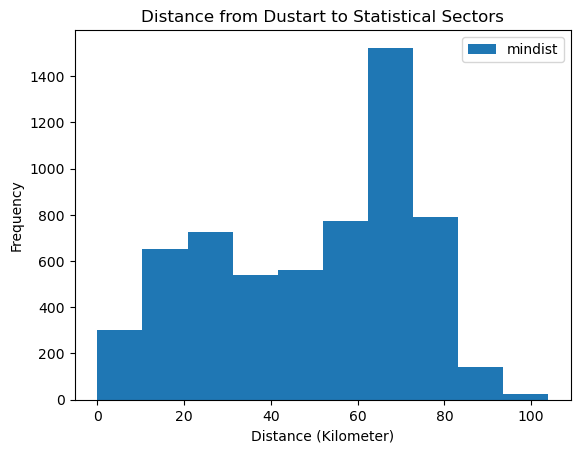

In [22]:
# Extrema:
# x_pct = 0   -> No min required population represented in selected SS => 1 cluster for DLG
# x_pct = 100 -> Full population needs to be represented in selected SS => # clusters = # SS in DLG
#                Note: # clusters can be < # SS in DLG if there are SS with POPULATION = 0
x_pct = 66

import numpy as np
from shapely.ops import unary_union, nearest_points

from geopy.geocoders import Photon
import pyproj
from shapely.geometry import Point
from shapely.ops import transform

wgs84 = pyproj.CRS("EPSG:4326")

photon_url = "imobwww.uhasselt.be/photon"
geolocator = Photon(user_agent="Python", domain=photon_url)
location = geolocator.geocode("Dusart Hasselt")
print(location.address)
print((location.latitude, location.longitude))
project = pyproj.Transformer.from_crs(wgs84, gdf_SS.crs, always_xy=True).transform
dusart = Point(location.longitude, location.latitude)
print(dusart)
dusart = transform(project, Point(location.longitude, location.latitude))
print(dusart)

location2 = geolocator.geocode("begijnenstraat diest")
print(location2.address)
print((location2.latitude, location2.longitude))
# project = pyproj.Transformer.from_crs(wgs84, gdf_SS.crs, always_xy=True).transform
diepenbeek = Point(location2.longitude, location2.latitude)
print(diepenbeek)
diepenbeek = transform(project, Point(location2.longitude, location2.latitude))
print(diepenbeek)

print(diepenbeek.distance(dusart))


# Get the number of the largest SS required to obtain x_pct of the POPULATION
# -np.sort(-x) sorts the series descending
# np.cumsum(-np.sort(-x)) generates total numbers of POPULATION by incrementally adding largest SS
# np.sum(x) = total inhabitants in DLG
# x_pct*np.sum(x)/100 : number of inhabitants in DLG that consitutes x_pct of total in DLG
# np.cumsum(-np.sort(-x))-x_pct*np.sum(x)/100 : becomes 0 for the n largest SS that cover x_pct of pop in DLG
# np.abs(...) becomes 0 for the element in the series for which the cumsum becomes x_pct of pop in DLG
# np.argmin( ...) computes the 0-based index of the value closest by 0
# ... + 1 : convert 0-based index to number of SS
def xpct(x):
    return np.argmin(np.abs(np.cumsum(-np.sort(-x)) - x_pct * np.sum(x) / 100)) + 1


def mindist(x):
    return min([dusart.distance(geom) for geom in x]) / 1000


# def mindist2(x): return dusart.distance(unary_union(x))
# def mindist(x): return min(dusart.distance(x))

# first test: compute the mean population ...
SS_pivot_gdf = gdf_decomposed.pivot_table(
    index="SS_s_plygn",
    values=["POPULATION", "geometry", "T_SEC_NL"],
    aggfunc={
        "POPULATION": ["count", xpct],
        "geometry": [mindist],
        "T_SEC_NL": "first",
    },
)
SS_pivot_gdf = SS_pivot_gdf.rename(
    columns={"xpct": f"n_pct_{x_pct}", "first": "T_SEC_NL"}
)
# Flatten multi level column index
SS_pivot_gdf.columns = [a[-1] for a in SS_pivot_gdf.columns.to_flat_index()]
# Reset Index to get the Name column back
SS_pivot_gdf = SS_pivot_gdf.reset_index()
print(SS_pivot_gdf)
#print(
#    SS_pivot_gdf.loc[
#        SS_pivot_gdf["T_NIS6_NL"].isin(["DIEPENBEEK", "HASSELT", "DIEST"])
#     ]
# )
print(gdf_SS.crs)

# Plot histogram with the distances
ax = SS_pivot_gdf.plot.hist(column="mindist")
ax.set_title("Distance from Dustart to Statistical Sectors")
ax.set_xlabel("Distance (Kilometer)")

# Decomposition of Multi-Polygons to Single Polygon within the Study Area

In [17]:
# import geopandas as gpd

# # Load the shapefile with building counts (previously saved)
# input_shapefile = "./data/SS_pop_bldng_cnts.shp"
# gdf = gpd.read_file(input_shapefile)

# # Ensure the CS01012023 column exists in the original GeoDataFrame
# if 'CS01012023' not in gdf.columns:
#     raise KeyError("'CS01012023' column not found in the input shapefile!")

# # Count the number of single polygons and multipolygons before decomposition
# num_polygons_before = len(gdf)
# num_single_polygons_before = gdf.geometry.geom_type.value_counts().get('Polygon', 0)
# num_multipolygons_before = gdf.geometry.geom_type.value_counts().get('MultiPolygon', 0)

# #print("Attributes before decomposition:")
# #print(gdf.head())
# print(f"Number of single polygons before decomposition: {num_single_polygons_before}")
# print(f"Number of multipolygons before decomposition: {num_multipolygons_before}")
# print(f"Total number of polygons before decomposition: {num_polygons_before}")

# # 2. Decompose multipolygons into single polygons, retaining the CS01012023 column
# gdf_decomposed = gdf.explode(index_parts=False).reset_index(drop=True)

# # 3. Ensure the CS01012023 column is present in the decomposed GeoDataFrame
# if 'CS01012023' not in gdf_decomposed.columns:
#     raise KeyError("'CS01012023' column missing after decomposition!")

# # Count the number of single polygons and multipolygons after decomposition
# num_polygons_after = len(gdf_decomposed)
# num_single_polygons_after = gdf_decomposed.geometry.geom_type.value_counts().get('Polygon', 0)
# num_multipolygons_after = gdf_decomposed.geometry.geom_type.value_counts().get('MultiPolygon', 0)

# # print("\nAttributes after decomposition:")
# #print(gdf_decomposed.head())
# print(f"Number of single polygons after decomposition: {num_single_polygons_after}")
# print(f"Number of multipolygons after decomposition: {num_multipolygons_after}")
# print(f"Total number of polygons after decomposition: {num_polygons_after}")

# # Validation step: check that there are no multipolygons after decomposition
# if num_multipolygons_after != 0:
#     print("Validation failed: There are still multipolygons present after decomposition!")
# else:
#     print("Validation succeeded: All multipolygons have been successfully exploded.")

# # 5. Create a new column 'SS_s_plygn' initialized with the values from 'CS01012023'
# gdf_decomposed['SS_s_plygn'] = gdf_decomposed['CS01012023']

# # 6. Add suffixes for decomposed polygons that were originally multipolygons
# for original_value, group in gdf_decomposed.groupby('CS01012023'):
#     if len(group) > 1:  # If this was a multipolygon
#         for i, idx in enumerate(group.index):
#             gdf_decomposed.loc[idx, 'SS_s_plygn'] = f"{original_value}{chr(65 + i)}"  # Add A, B, C...

# # 7. Save the decomposed shapefile
# decomposed_output_path = "./data/SS_pop_bldng_cnts_decomposed.shp"
# gdf_decomposed.to_file(decomposed_output_path)

# # Load building centroids again (previously extracted from OSM)
# bldng_centroids = gpd.read_file("./data/bldng_centroids.shp")

# # Ensure both GeoDataFrames have the same CRS
# if gdf_decomposed.crs != bldng_centroids.crs:
#     bldng_centroids = bldng_centroids.to_crs(gdf_decomposed.crs)

# # 8. Spatial join: Assign building centroids to the decomposed polygons
# joined_gdf = gpd.sjoin(
#     gdf_decomposed,
#     bldng_centroids,
#     how="inner",
#     predicate="intersects",
# )

# # 9. Group by the new unique index and count buildings per single polygon
# ss_count_bldngs_post = joined_gdf.groupby(
#     joined_gdf.index,  # group by the new index of the decomposed polygons
#     as_index=True,  # Ensure index is retained
# )["building"].count()  # count the number of buildings per polygon

# # Rename the column to reflect post-decomposition building counts
# ss_count_bldngs_post = ss_count_bldngs_post.rename("bldng_post")

# # 10. Merge the post-decomposition counts into the decomposed GeoDataFrame
# gdf_cnts_post = gdf_decomposed.merge(
#     ss_count_bldngs_post,
#     left_index=True,
#     right_index=True,  # Merge on index (both left and right)
#     how="left",
# )

# # 11. Handle missing values (polygons without buildings)
# gdf_cnts_post["bldng_post"].fillna(0, inplace=True)

# # Convert building counts to integer
# gdf_cnts_post = gdf_cnts_post.astype({"bldng_post": "int"})

# # 12. Save the final output shapefile
# output_post_decomp_path = "./data/SS_pop_bldng_cnts_post_decomp_correct.shp"
# gdf_cnts_post.to_file(output_post_decomp_path)

# # Write out the SS_s_plygn column from gdf_cnts_post to gdf_SS
# gdf_SS['SS_s_plygn'] = gdf_cnts_post['SS_s_plygn']

# # 13. Print final results
# print("\nFinal GeoDataFrame with post-decomposition building counts and SS_s_plygn:")
# print(gdf_cnts_post.head())
# print(f"Saved final shapefile to {output_post_decomp_path}")


# Building Fractions & Population Redistribution
 This step done after the Decomposition of Multi-polygons to Single Polygons

In [18]:
# import geopandas as gpd
# import pandas as pd
# import numpy as np

# # Load the decomposed shapefile with building counts (saved previously)
# input_shapefile = "./data/SS_pop_bldng_cnts_post_decomp_correct.shp"
# gdf_decomposed = gpd.read_file(input_shapefile)

# # 1. Ensure the original multipolygon building counts and population columns are present
# original_shapefile = "./data/SS_pop_bldng_cnts.shp"
# gdf_original = gpd.read_file(original_shapefile)

# # 2. Calculate frac_bldng: the fraction of buildings in single polygons compared to multipolygon
# gdf_decomposed['frac_bldng'] = gdf_decomposed['bldng_post'] / gdf_decomposed['bldng_cnt']

# # Handle cases where the original building count is zero to avoid division by zero
# gdf_decomposed['frac_bldng'].fillna(0, inplace=True)

# # 3. Calculate POP_UPD: distribute population based on building fraction
# gdf_decomposed['POP_UPD'] = gdf_decomposed['POPULATION']  # Initialize with original population

# # Retain original values of POPULATION where frac_bldng == 1 or where frac_bldng is 0
# gdf_decomposed.loc[gdf_decomposed['frac_bldng'] == 1, 'POP_UPD'] = gdf_decomposed['POPULATION']
# gdf_decomposed.loc[gdf_decomposed['frac_bldng'] == 0, 'POP_UPD'] = gdf_decomposed['POPULATION']

# # Distribute population for other cases
# gdf_decomposed['POP_UPD'] = np.where(
#     gdf_decomposed['frac_bldng'] != 0,
#     gdf_decomposed['frac_bldng'] * gdf_decomposed['POPULATION'],
#     gdf_decomposed['POP_UPD']  # Retain original for frac_bldng == 0
# )

# # Round to the nearest whole number for the updated population
# gdf_decomposed['POP_UPD'] = gdf_decomposed['POP_UPD'].round().astype(int)

# # 4. Ensure the values sum correctly across polygons
# original_population_sum = gdf_original['POPULATION'].sum()
# new_population_sum = gdf_decomposed['POP_UPD'].sum()

# if original_population_sum != new_population_sum:
#     # Adjust the last polygon to balance the population sum if there's a difference
#     adjustment = original_population_sum - new_population_sum
#     gdf_decomposed.iloc[-1, gdf_decomposed.columns.get_loc('POP_UPD')] += adjustment

# # 5. Ensure frac_bldng remains in decimal values
# gdf_decomposed['frac_bldng'] = gdf_decomposed['frac_bldng']  # No conversion to percentage needed

# # 6. Save the updated shapefile with frac_bldng and POP_UPD columns
# output_path = "./data/SS_pop_bldng_cnts_with_population_Updated.shp"
# gdf_decomposed.to_file(output_path)

# # 7. Write an Excel file for comparison of the attributes
# excel_output_path = "./data/comparison_attributes.xlsx"
# gdf_decomposed.to_excel(excel_output_path, index=False)

# # 8. Print sample rows to check the results
# print(gdf_decomposed[['bldng_post', 'bldng_cnt', 'frac_bldng', 'POPULATION', 'POP_UPD']].head())
# print(f"Saved the updated shapefile to {output_path}")
# print(f"Saved the comparison attributes to {excel_output_path}")


Make a plot using Matplotlib

# Clustering van de gebouwen in groepen

https://samdotson1992.github.io/SuperGIS/blog/k-means-clustering/
https://darribas.org/gds15/content/labs/lab_08.html

https://gis.stackexchange.com/questions/309087/how-to-create-a-geodataframe-points-grid-from-a-numpy-mgrid

https://stackoverflow.com/questions/50971914/what-is-the-most-efficient-way-to-convert-numpy-arrays-to-shapely-points

Selecteer eerst enkel gebouwen in Halen (T_NIS6_NL="HALEN")


In [23]:
# Selecteer Halen als gebied om gebouwen mee te selecteren
#gdf_halen = gdf_SS[gdf_SS.T_MUN_NL == "Hasselt"].dissolve(by='T_MUN_NL')
# Fix issues met Memory leak op Windows
# https://stackoverflow.com/questions/69596239/how-to-avoid-memory-leak-when-dealing-with-kmeans-for-example-in-this-code-i-am

# Use slugify to remove invalid characters from autogenerated paths
# mamba install -c conda-forge python-slugify
from slugify import slugify
import os

os.environ["OMP_NUM_THREADS"] = "1"

from colorama import Fore
from colorama import Style
from shapely.geometry import Point

import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import math

# Store the centroids for the cluster, including their cluster ID (cluster)
# Note that clusters with the same label for different DLG have no relation.
gdf_ccentroids = geopandas.GeoDataFrame(
    columns=["X", "Y", "cluster", "geometry"], geometry="geometry", crs=gdf_decomposed.crs
)
gdf_centroids = geopandas.GeoDataFrame(
    columns=[
        "building",
        "amenity",
        "area",
        "CNIS_PROVI",
        "CNIS_REGIO",
        "CS01012023",
        "T_ARRD_NL",
        "T_MUN_NL",
        "T_NIS6_NL",
        "T_SEC_NL",
        "POPULATION",
        "cluster",
        "geometry",
    ],
    geometry="geometry",
)

cluster_offset = 0  # Offset to generate unique cluster IDs over DLG

# Iterate over statistical sectors
# for i_dlg in gdf_SS.sort_values(by=['T_MUN_NL', 'T_NIS6_NL'])['T_NIS6_NL'].unique():
# Sort on the names (T attributes) but group on the codes/indices (C attributes) to deal with duplicate naming
# Replace null values in 'T_SEC_NL' (i_ss_name) with the corresponding 'T_NIS6_NL' value
gdf_decomposed['T_SEC_NL'].fillna(gdf_decomposed['T_NIS6_NL'], inplace=True)
for group_k, group_v in gdf_decomposed.sort_values(by=["T_SEC_NL"]).groupby(
    by=["SS_s_plygn"], sort=False
):
    i_ss = group_k[0]  # group_k is a tuple
    

    # group_v is a Pandas Series of (identical) values for each member of the group, take the first element
    
    i_ss_name = group_v["T_SEC_NL"].iloc[0] # Get the name, now with nulls handled
    if i_ss_name is None:
        print("Error: `i_ss_name` is None, cannot create directory.")
        continue  # Skip to the next iteration if the name is missing


    else:
        print("Error: `i_ss_name` is None, cannot create directory.")
    # Determine municipality (gemeente) to which the submunicipality (deelgemeente) belongs
    # BUG : this finds multiple GEM for DLG with the same name, e.g. Halle (Halle) and Halle (Zoersel)
    #       no major issue, but double processing
    # i_gem = gdf_SS[gdf_SS["T_NIS6_NL"] == i_dlg].iloc[0]["T_MUN_NL"]

    # Switch for testing
    if True:
        #    if i_gem_name in [ 'Deurne', 'Halle', 'Diest', 'Hasselt', 'Diepenbeek']:
        # Note: Deurne only exists as DLG, not as GEM. So it should not pop up in the list
        print(f"{Fore.YELLOW}Processing {i_ss_name} {Style.RESET_ALL}")

        # Create folder for DLG specific data
        os.makedirs(
            f"./data/{slugify(i_ss_name)}", exist_ok=True
        )  # create data folder if not exist

        # Retrieve the number of the largest SS required to cover x_pct of the i_dlg population
        # This will be the lower bound of the number of clusters
        # (Use iloc[0] and not [0] as there is no row index starting from 0)
        n_x_pct = SS_pivot_gdf.loc[
            SS_pivot_gdf["SS_s_plygn"] == i_ss, f"n_pct_{x_pct}"
        ].iloc[0]
        mindist = SS_pivot_gdf.loc[SS_pivot_gdf["SS_s_plygn"] == i_ss, "mindist"].iloc[0]

        # Select the ss falling withing i_ss
        ss_i_dlg_gdf = gdf_cnts_post[gdf_cnts_post["SS_s_plygn"] == i_ss]

        # Only keep building centroids falling within i_ss
        bldng_centroids_dlg = bldng_centroids.overlay(
            ss_i_dlg_gdf, how="intersection", make_valid=True
        )
        a = pd.Series(bldng_centroids_dlg["geometry"].apply(lambda p: p.x))
        b = pd.Series(bldng_centroids_dlg["geometry"].apply(lambda p: p.y))
        X = np.column_stack((a, b))

        silhouette_coefficients = {}
        n_ss = len(ss_i_dlg_gdf)  # number of statistical sectors
        print(f"Number of statistical sectors: {n_ss}")
        # We can't cluster without points (e.g. Spalbeek (Hasselt)), report and skip
        n_bldng_dlg = len(
            bldng_centroids_dlg
        )  # number of buildings in SS (= number of samples in dataset)
        if n_bldng_dlg == 0:
            print(f"No points to cluster found in SS. Moving on ...")
            continue
        print(f"Number of buildings in SS: {n_bldng_dlg}")
        print(
            f"{n_x_pct} largest SS contain(s) at least {x_pct}% of the {i_ss_name} population"
        )

        # Try different number of clusters, ranging from the amount of SS needed to cover x_pct of the population of the DLG up to
        # the number of SS in the DLG
        if mindist < 25:
            n_clust_min = 4  # Minimal amount of clusters for DLG
            n_clust_max = 8 # Maximal amount of clusters for DLG
        elif mindist < 50:
            n_clust_min = 2
            n_clust_max = 4
        else:
            n_clust_min = 1
            n_clust_max = 1
        if n_clust_max < n_clust_min:
            n_clust_min = n_clust_max

        # entry of iteration loop for feedback from previous clustering
        repeat_dlg_clustering = True
        while repeat_dlg_clustering:
            # If we have less samples than the minimal number of clusters, reduce number of clusters
            if n_clust_min > n_bldng_dlg:
                n_clust_min = n_bldng_dlg
            # If we have less samples than the maximal number of clusters, reduce number of clusters
            if n_clust_max > n_bldng_dlg:
                n_clust_max = n_bldng_dlg
            for i_n_clust in range(n_clust_min, n_clust_max + 1):
                kmeans = KMeans(
                    n_clusters=i_n_clust,
                    init="k-means++",
                    random_state=42,
                    n_init="auto",
                )
                kmeans.fit(X)

                # Initialise Silhouette score to worst possible value
                sil_coeff = -1
                if i_n_clust > 1 and i_n_clust < n_bldng_dlg:
                    # Compute Silhouette score if it can be computed (requires at least 2 clusters/labels)
                    sil_coeff = silhouette_score(X, kmeans.labels_, metric="euclidean")
                elif i_n_clust > 1 and i_n_clust == n_bldng_dlg:
                    # If the number of clusters is equal to the number of observations, we can get a perfect match
                    # but can't compute the silhouette function. Set it to max value (1)
                    sil_coeff = 1
                silhouette_coefficients[i_n_clust] = sil_coeff

                # Compute the classes for the centroids (which might be silly as they are probably the row index of kmeans.labels_, but can't find it in the documentation now. Better be safe.)
                Xcentroids = np.column_stack(
                    (kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1])
                )
                y_centroids = kmeans.predict(Xcentroids)

                print(
                    f"# clusters: {i_n_clust}, Inertia: {kmeans.inertia_}, Silhouette coefficient: {sil_coeff}"
                )

                # Create dataframe with the cluster centroids and the labels of the clusters
                df_ccentroids_tmp = pd.DataFrame(
                    {
                        "X": kmeans.cluster_centers_[:, 0],
                        "Y": kmeans.cluster_centers_[:, 1],
                        "cluster": y_centroids,
                    }
                )
                # df_ccentroids_tmp.apply(lambda row: print(row), axis=1)
                df_ccentroids_tmp["geometry"] = df_ccentroids_tmp.apply(
                    lambda row: Point(row["X"], row["Y"]), axis=1
                )
                # print(gdf_cnts.crs) # find better way to set crs
                gdf_ccentroids_tmp = gpd.GeoDataFrame(df_ccentroids_tmp).set_crs(
                    crs=gdf_cnts.crs
                )
                gdf_ccentroids_tmp.to_file(
                    f"./data/{slugify(i_ss_name)}/clusters_{slugify(i_ss_name)}_{i_n_clust}_centroids.shp"
                )

                # Create dataframe with classes added to the building centroids
                y_kmeans = kmeans.predict(X)
                # Todo: bovenstaand is gelijk aan kmeans.labels_ ??
                df_centroids_tmp = pd.DataFrame(y_kmeans, columns=["cluster"])
                df_centroids_tmp = df_centroids_tmp.assign(n_ss=n_ss)
                gdf_centroids_tmp = bldng_centroids_dlg.join(df_centroids_tmp)
                gdf_centroids_tmp.to_file(
                    f"./data/{slugify(i_ss_name)}/clusters_{slugify(i_ss_name)}_{i_n_clust}.shp"
                )

            # Get the smallest number of clusters (dict key) that has the highest sihouette function value (dict value)
            optimal_nr_clusters = max(
                sorted(silhouette_coefficients), key=silhouette_coefficients.get
            )
            print(
                f"Optimal number of clusters: {Fore.RED}{optimal_nr_clusters}{Style.RESET_ALL}"
            )

            # Now we have found the optimal number of clusters, rerun the clustering to test and export the data
            kmeans = KMeans(
                n_clusters=optimal_nr_clusters,
                init="k-means++",
                random_state=42,
                n_init="auto",
            )
            kmeans.fit(X)
            y_kmeans = kmeans.predict(X) + cluster_offset

            # Test whether the clusters found are acceptable
            df_centroids_tmp = pd.DataFrame(y_kmeans, columns=["cluster"])
            gdf_centroids_tmp = bldng_centroids_dlg.join(df_centroids_tmp)

            # compute the convex hull of a geoseries (of points); this is used to compute the convex hull of the cluster
            # convex_hull on a geoseries is the geoseries of the convex hulls
            # so we first have to union the points in our geoseries before computing the convex hull
            def clustarea(x):
                return x.unary_union.convex_hull.area

            gdf_cluster_polygons = gdf_centroids_tmp.pivot_table(
                index="cluster", values=["geometry"], aggfunc={"geometry": [clustarea]}
            )
            # Flatten multi level column index
            gdf_cluster_polygons.columns = [
                a[-1] for a in gdf_cluster_polygons.columns.to_flat_index()
            ]
            # Set constraints on the size of the clusters (to manage travel time within the cluster)
            max_cluster_area = 1000000000
            if mindist < 25:
                max_cluster_area = math.pi * math.pow(
                    1000, 2
                )  # circle with 1000m radius
            elif mindist < 50:
                max_cluster_area = math.pi * math.pow(
                    2500, 2
                )  # circle with 2500m radius
            else:
                max_cluster_area = math.pi * math.pow(
                    5000, 2
                )  # circle with 5000m radius

            n_too_large = len(
                gdf_cluster_polygons.loc[
                    gdf_cluster_polygons["clustarea"] > max_cluster_area
                ]
            )
            if n_too_large > 0:
                # Increase number of clusters with 1
                optimal_nr_clusters += 1
                silhouette_coefficients = {}  # Reset silhouette coefficients
                print(
                    f"{n_too_large} clusters have an area larger than ({round(max_cluster_area)}). Increasing # clusters to {optimal_nr_clusters}"
                )
                n_clust_min = optimal_nr_clusters
                n_clust_max = optimal_nr_clusters
                repeat_dlg_clustering = True  # recluster
            else:
                repeat_dlg_clustering = False  # Stop iteration

        # Clusters found for the DLG are ok, export
        df_centroids_tmp = pd.DataFrame(y_kmeans, columns=["cluster"])
        gdf_centroids_tmp = bldng_centroids_dlg.join(df_centroids_tmp)
        gdf_centroids_tmp.to_file(
            f"./data/{slugify(i_ss_name)}/clusters_{slugify(i_ss_name)}_optimal.shp"
        )

        # Add centroids to global layer with labeled building centroids
        # Added check if dataframes are empty to avoid deprecation warning for concat of empty dataframes
        gdf_centroids = (
            gdf_centroids_tmp
            if gdf_centroids.empty
            else pd.concat([gdf_centroids, gdf_centroids_tmp])
        )

        # Compute the classes for the centroids (which might be silly as they are probably the row index of kmeans.labels_, but can't find it in the documentation now. Better be safe.)
        Xcentroids = np.column_stack(
            (kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1])
        )
        y_centroids = kmeans.predict(Xcentroids)
        # Create dataframe with the cluster centroids and the labels of the clusters
        df_ccentroids_tmp = pd.DataFrame(
            {
                "X": kmeans.cluster_centers_[:, 0],
                "Y": kmeans.cluster_centers_[:, 1],
                "cluster": y_centroids + cluster_offset,
            }
        )
        df_ccentroids_tmp["geometry"] = df_ccentroids_tmp.apply(
            lambda row: Point(row["X"], row["Y"]), axis=1
        )
        # todo: find better way to set crs
        gdf_ccentroids_tmp = gpd.GeoDataFrame(df_ccentroids_tmp).set_crs(
            crs=gdf_cnts.crs
        )
        gdf_ccentroids_tmp.to_file(
            f"./data/{slugify(i_ss_name)}/clusters_{slugify(i_ss_name)}_optimal_centroids.shp"
        )

        # Add ccentroids to global layer with cluster centroids
        # Added check if dataframes are empty to avoid deprecation warning for concat of empty dataframes
        gdf_ccentroids = (
            gdf_ccentroids_tmp
            if gdf_ccentroids.empty
            else pd.concat([gdf_ccentroids, gdf_ccentroids_tmp])
        )

        # Update cluster offset
        cluster_offset += optimal_nr_clusters

# Write all centroids to file
gdf_centroids.to_file(f"./data/clusters_optimal.shp")
# Write all ccentroids to file
gdf_ccentroids.to_file(f"./data/clusters_optimal_centroids.shp")

Error: `i_ss_name` is None, cannot create directory.
Processing "T LAMMEKEN 
Number of statistical sectors: 1
No points to cluster found in SS. Moving on ...
Error: `i_ss_name` is None, cannot create directory.
Processing "T ZAND - WATERINGEN 
Number of statistical sectors: 1
No points to cluster found in SS. Moving on ...
Error: `i_ss_name` is None, cannot create directory.
Processing 'S GRAVENVOEREN -VERSPR. BEW. 
Number of statistical sectors: 1
No points to cluster found in SS. Moving on ...
Error: `i_ss_name` is None, cannot create directory.
Processing 'S GRAVENVOEREN-KERN 
Number of statistical sectors: 1
No points to cluster found in SS. Moving on ...
Error: `i_ss_name` is None, cannot create directory.
Processing 'S GRAVENWEZEL-CENTRUM 
Number of statistical sectors: 1
No points to cluster found in SS. Moving on ...
Error: `i_ss_name` is None, cannot create directory.
Processing 'S GRAVENWEZEL-VERSPR. BEW. ZUID-WEST 
Number of statistical sectors: 1
No points to cluster found 

In [ ]:
# Filter the dataframe to exclude rows where the 'POPULATION' column is blank or zero
filtered_gdf_SS = gdf_SS[(gdf_SS['POPULATION'].notna()) & (gdf_SS['POPULATION'] > 0)]

# Count the number of unique sub-municipalities in the filtered dataframe
unique_count = filtered_gdf_SS['T_MUN_NL'].nunique()

# Print the result
print(f"Number of unique sub-municipalities (with non-blank and non-zero population): {unique_count}")


# Creating Voronoi around Building Points from OSM


In [26]:
import geopandas as gpd
from shapely.geometry import Polygon
from scipy.spatial import Voronoi
import numpy as np

# Load the zone shapefile (Statistical Sectors)
zones_gdf = gpd.read_file(r'G:\\My Drive\\PhD Folder\\Repositories\\p22-23-csbostrauss\\Regions\\Hasselt\data\SS_pop_bldng_cnts_post_decomp_correct.shp')

# Load the building points shapefile (OSM points)
points_gdf = gpd.read_file(r'G:\\My Drive\\PhD Folder\\Repositories\\p22-23-csbostrauss\\Regions\\Hasselt\\data\\clusters_optimal.shp')

# Ensure both GeoDataFrames have the same CRS
zones_gdf = zones_gdf.to_crs(points_gdf.crs)

# Function to create Voronoi polygons clipped to a boundary
def create_voronoi(points, boundary, buffer_factor=2.0):
    # Get coordinates of the points
    coords = np.array([(point.x, point.y) for point in points.geometry])

    # Add boundary points to ensure coverage beyond the convex hull of points
    minx, miny, maxx, maxy = boundary.bounds

    # Expand the boundary by a factor for larger coverage
    boundary_points = np.array([
        [minx - (maxx - minx) * (buffer_factor - 1), miny - (maxy - miny) * (buffer_factor - 1)],
        [minx - (maxx - minx) * (buffer_factor - 1), maxy + (maxy - miny) * (buffer_factor - 1)],
        [maxx + (maxx - minx) * (buffer_factor - 1), miny - (maxy - miny) * (buffer_factor - 1)],
        [maxx + (maxx - minx) * (buffer_factor - 1), maxy + (maxy - miny) * (buffer_factor - 1)]
    ])

    # Combine building points and boundary points
    all_points = np.vstack([coords, boundary_points])

    # Compute Voronoi tessellation for all points
    vor = Voronoi(all_points)

    # Create Voronoi polygons and clip them to the boundary
    polygons = []
    for region in vor.regions:
        if not -1 in region and len(region) > 0:
            polygon = Polygon([vor.vertices[i] for i in region])
            # Clip the Voronoi polygon to the boundary of the statistical sector
            clipped_polygon = polygon.intersection(boundary)
            if not clipped_polygon.is_empty:
                polygons.append(clipped_polygon)
    
    return polygons

# Initialize an empty list to store tessellated polygons for each zone
tessellated_zones = []

for _, zone in zones_gdf.iterrows():
    # Get the boundary of the current statistical sector
    zone_boundary = zone['geometry']

    # Filter points within the current statistical sector
    points_in_zone = points_gdf[points_gdf.within(zone_boundary)]

    if len(points_in_zone) > 0:
        # Handle case with fewer than 3 points by using just the zone boundary
        if len(points_in_zone) == 1:
            # For one point, fill the whole sector
            tessellated_zones.append({
                'geometry': zone_boundary,  # Use the boundary directly
                'zone_id': zone['SS_s_plygn']  # Assuming this is the correct column for zone id
            })
        else:
            # Create Voronoi polygons for more than one point in the statistical sector
            voronoi_polygons = create_voronoi(points_in_zone, zone_boundary)
            for poly in voronoi_polygons:
                tessellated_zones.append({
                    'geometry': poly,
                    'zone_id': zone['SS_s_plygn']  # Assuming this is the correct column for zone id
                })

# Convert the tessellated zones into a GeoDataFrame
voronoi_gdf = gpd.GeoDataFrame(tessellated_zones, crs=zones_gdf.crs)

# Ensure both Voronoi and points GeoDataFrames have the same CRS
voronoi_gdf = voronoi_gdf.to_crs(points_gdf.crs)

# Step 1: Create spatial indexes for both GeoDataFrames
voronoi_gdf.sindex
points_gdf.sindex

# Step 2: Perform a spatial join (join points with Voronoi polygons by location)
# Using 'contains' since each Voronoi polygon should contain the respective building point
joined_gdf = gpd.sjoin(voronoi_gdf, points_gdf, how='inner', predicate='contains')

# Step 3: Dissolve geometries based on the 'cluster' field
# Grouping Voronoi polygons by the 'cluster' field (assuming it's from the points_gdf)
dissolved_gdf = joined_gdf.dissolve(by='cluster', as_index=False)

# Step 4: Save the dissolved Voronoi polygons to a new shapefile
output_path = r'G:\\My Drive\\PhD Folder\\Repositories\\p22-23-csbostrauss\\Regions\\Hasselt\\data\\dissolved_voronoi_clusters.shp'
dissolved_gdf.to_file(output_path)

print("Voronoi polygons dissolved by cluster and saved successfully.")


C:\Users\lucp13374\AppData\Local\Temp\ipykernel_28752\676789555.py:96: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  dissolved_gdf.to_file(output_path)


Voronoi polygons dissolved by cluster and saved successfully.


In [27]:
# import geopandas as gpd
# from shapely.geometry import Polygon
# from scipy.spatial import Voronoi
# import numpy as np

# # Load the zone shapefile (Statistical Sectors)
# zones_gdf = gpd.read_file(r'G:\\My Drive\\PhD Folder\\Repositories\\p22-23-csbostrauss\\Regions\\Hasselt\data\SS_pop_bldng_cnts_post_decomp_correct.shp')

# # Load the building points shapefile (OSM points)
# points_gdf = gpd.read_file(r'G:\\My Drive\\PhD Folder\\Repositories\\p22-23-csbostrauss\\Regions\\Hasselt\\data\\clusters_optimal.shp')

# # Ensure both GeoDataFrames have the same CRS
# zones_gdf = zones_gdf.to_crs(points_gdf.crs)

# # Function to create Voronoi polygons clipped to a boundary
# def create_voronoi(points, boundary, buffer_factor=2.0):
#     # Get coordinates of the points
#     coords = np.array([(point.x, point.y) for point in points.geometry])

#     # Add boundary points to ensure coverage beyond the convex hull of points
#     minx, miny, maxx, maxy = boundary.bounds

#     # Expand the boundary by a factor for larger coverage
#     boundary_points = np.array([
#         [minx - (maxx - minx) * (buffer_factor - 1), miny - (maxy - miny) * (buffer_factor - 1)],
#         [minx - (maxx - minx) * (buffer_factor - 1), maxy + (maxy - miny) * (buffer_factor - 1)],
#         [maxx + (maxx - minx) * (buffer_factor - 1), miny - (maxy - miny) * (buffer_factor - 1)],
#         [maxx + (maxx - minx) * (buffer_factor - 1), maxy + (maxy - miny) * (buffer_factor - 1)]
#     ])

#     # Combine building points and boundary points
#     all_points = np.vstack([coords, boundary_points])

#     # Compute Voronoi tessellation for all points
#     vor = Voronoi(all_points)

#     # Create Voronoi polygons and clip them to the boundary
#     polygons = []
#     for region in vor.regions:
#         if not -1 in region and len(region) > 0:
#             polygon = Polygon([vor.vertices[i] for i in region])
#             # Clip the Voronoi polygon to the boundary of the statistical sector
#             clipped_polygon = polygon.intersection(boundary)
#             if not clipped_polygon.is_empty:
#                 polygons.append(clipped_polygon)
    
#     return polygons

# # Initialize an empty list to store tessellated polygons for each zone
# tessellated_zones = []

# for _, zone in zones_gdf.iterrows():
#     # Get the boundary of the current statistical sector
#     zone_boundary = zone['geometry']

#     # Filter points within the current statistical sector
#     points_in_zone = points_gdf[points_gdf.within(zone_boundary)]

#     if len(points_in_zone) > 0:
#         # Handle case with fewer than 3 points by using just the zone boundary
#         if len(points_in_zone) == 1:
#             # For one point, fill the whole sector
#             tessellated_zones.append({
#                 'geometry': zone_boundary,  # Use the boundary directly
#                 'zone_id': zone['SS_s_plygn']  # Assuming this is the correct column for zone id
#             })
#         else:
#             # Create Voronoi polygons for more than one point in the statistical sector
#             voronoi_polygons = create_voronoi(points_in_zone, zone_boundary)
#             for poly in voronoi_polygons:
#                 tessellated_zones.append({
#                     'geometry': poly,
#                     'zone_id': zone['SS_s_plygn']  # Assuming this is the correct column for zone id
#                 })

# # Convert the tessellated zones into a GeoDataFrame
# voronoi_gdf = gpd.GeoDataFrame(tessellated_zones, crs=zones_gdf.crs)

# # Ensure both Voronoi and points GeoDataFrames have the same CRS
# voronoi_gdf = voronoi_gdf.to_crs(points_gdf.crs)

# # Step 1: Create spatial indexes for both GeoDataFrames
# voronoi_gdf.sindex
# points_gdf.sindex

# # Step 2: Perform a spatial join (join points with Voronoi polygons by location)
# # Using 'contains' since each Voronoi polygon should contain the respective building point
# joined_gdf = gpd.sjoin(voronoi_gdf, points_gdf, how='inner', predicate='contains')

# # Step 3: Dissolve geometries based on the 'cluster' field
# # Grouping Voronoi polygons by the 'cluster' field (assuming it's from the points_gdf)
# dissolved_gdf = joined_gdf.dissolve(by='cluster', as_index=False)

# # Step 4: Save the dissolved Voronoi polygons to a new shapefile
# output_path = r'G:\\My Drive\\PhD Folder\\Repositories\\p22-23-csbostrauss\\Regions\\Hasselt\\data\\dissolved_voronoi_clusters.shp'
# dissolved_gdf.to_file(output_path)

# print("Voronoi polygons dissolved by cluster and saved successfully.")


# Creating Voronoi using Centroids of Buildings 


In [28]:
import geopandas as gpd
from shapely.geometry import Polygon, Point
from scipy.spatial import Voronoi
import numpy as np
import pandas as pd

# Load the zone shapefile (Statistical Sectors)
zones_gdf = gpd.read_file(r'G:\\My Drive\\PhD Folder\\Repositories\\p22-23-csbostrauss\\Regions\\Hasselt\data\SS_pop_bldng_cnts_post_decomp_correct.shp')

# Load the building points shapefile (OSM points)
points_gdf = gpd.read_file(r'G:\\My Drive\\PhD Folder\\Repositories\\p22-23-csbostrauss\\Regions\\Hasselt\\data\\clusters_optimal.shp')

# Ensure both GeoDataFrames have the same CRS
zones_gdf = zones_gdf.to_crs(points_gdf.crs)

# Filter zones that fall within the region of points
intersecting_zones = zones_gdf[zones_gdf.intersects(points_gdf.unary_union)]

# Function to create Voronoi polygons clipped to a boundary
def create_voronoi(points, boundary, buffer_factor=2.0):
    # Get coordinates of the points
    coords = np.array([(point.x, point.y) for point in points.geometry])

    # Add boundary points to ensure coverage beyond the convex hull of points
    minx, miny, maxx, maxy = boundary.bounds

    # Expand the boundary by a factor for larger coverage
    boundary_points = np.array([
        [minx - (maxx - minx) * (buffer_factor - 1), miny - (maxy - miny) * (buffer_factor - 1)],
        [minx - (maxx - minx) * (buffer_factor - 1), maxy + (maxy - miny) * (buffer_factor - 1)],
        [maxx + (maxx - minx) * (buffer_factor - 1), miny - (maxy - miny) * (buffer_factor - 1)],
        [maxx + (maxx - minx) * (buffer_factor - 1), maxy + (maxy - miny) * (buffer_factor - 1)]
    ])

    # Combine building points and boundary points
    all_points = np.vstack([coords, boundary_points])

    # Compute Voronoi tessellation for all points
    vor = Voronoi(all_points)

    # Create Voronoi polygons and clip them to the boundary
    polygons = []
    for region in vor.regions:
        if not -1 in region and len(region) > 0:
            polygon = Polygon([vor.vertices[i] for i in region])
            # Clip the Voronoi polygon to the boundary of the statistical sector
            clipped_polygon = polygon.intersection(boundary)
            if not clipped_polygon.is_empty:
                polygons.append(clipped_polygon)
    
    return polygons

# Initialize an empty list to store tessellated polygons for each zone
tessellated_zones = []

# Initialize a list to store new points
new_points = []

for _, zone in intersecting_zones.iterrows():
    # Get the boundary of the current statistical sector
    zone_boundary = zone['geometry']

    # Filter points within the current statistical sector
    points_in_zone = points_gdf[points_gdf.within(zone_boundary)]

    if len(points_in_zone) == 0:
        # If no points exist in the zone, add a point at the centroid of the zone
        centroid_point = zone_boundary.centroid
        new_points.append(centroid_point)
        print(f"Added point at centroid for zone ID: {zone['SS_s_plygn']}")  # Provide feedback on which zone

    if len(points_in_zone) > 0 or len(new_points) > 0:  # Check if points exist or if a centroid point was added
        # Handle case with fewer than 3 points by using just the zone boundary
        if len(points_in_zone) == 1:
            # For one point, fill the whole sector
            tessellated_zones.append({
                'geometry': zone_boundary,  # Use the boundary directly
                'zone_id': zone['SS_s_plygn']  # Assuming this is the correct column for zone id
            })
        else:
            # Create Voronoi polygons for more than one point in the statistical sector
            all_points_in_zone = points_in_zone.append(gpd.GeoDataFrame(geometry=new_points, crs=points_gdf.crs)) if new_points else points_in_zone
            voronoi_polygons = create_voronoi(all_points_in_zone, zone_boundary)
            for poly in voronoi_polygons:
                tessellated_zones.append({
                    'geometry': poly,
                    'zone_id': zone['SS_s_plygn']  # Assuming this is the correct column for zone id
                })

# Create a GeoDataFrame from the new points, if any were added
if new_points:
    new_points_gdf = gpd.GeoDataFrame(geometry=new_points, crs=points_gdf.crs)
    
    # Concatenate the new points with the existing points GeoDataFrame
    points_gdf = pd.concat([points_gdf, new_points_gdf], ignore_index=True)

# Convert the tessellated zones into a GeoDataFrame
voronoi_gdf = gpd.GeoDataFrame(tessellated_zones, crs=zones_gdf.crs)

# Ensure both Voronoi and points GeoDataFrames have the same CRS
voronoi_gdf = voronoi_gdf.to_crs(points_gdf.crs)

# Step 1: Create spatial indexes for both GeoDataFrames
voronoi_gdf.sindex
points_gdf.sindex

# Step 2: Perform a spatial join (join points with Voronoi polygons by location)
# Using 'contains' since each Voronoi polygon should contain the respective building point
joined_gdf = gpd.sjoin(voronoi_gdf, points_gdf, how='inner', predicate='contains')

# Step 3: Dissolve geometries based on the 'cluster' field
# Grouping Voronoi polygons by the 'cluster' field (assuming it's from the points_gdf)
dissolved_gdf = joined_gdf.dissolve(by='cluster', as_index=False)

# Step 4: Save the dissolved Voronoi polygons to a new shapefile
output_path = r'G:\\My Drive\\PhD Folder\\Repositories\\p22-23-csbostrauss\\Regions\\Hasselt\\data\\dissolved_voronoi_c_clusters.shp'
dissolved_gdf.to_file(output_path)

print("Voronoi polygons dissolved by cluster and saved successfully.")


C:\Users\lucp13374\AppData\Local\Temp\ipykernel_28752\1730567345.py:117: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  dissolved_gdf.to_file(output_path)


Voronoi polygons dissolved by cluster and saved successfully.
